## Fase 1 do projeto MD-TP4

#### Passo 1

Aqui somente carregamos os dados para dataframes pandas

In [1]:
from src.loading import *

pricesDf

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0
...,...,...,...,...,...,...,...
851259,2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0
851260,2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0
851261,2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0
851262,2016-12-30 00:00:00,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0


#### Passo 2

Lidando com valores invalidos ou faltantes (objetivo principal deste passo)

Alem disso, foi necessario formatar os dados. Decidi-use formatar os dados antes
de testar por valores faltantes, para garantir que a formatacao nao introduziu
nenhum.

O resultado deste passo eh um dataset que pode ser usado no passo 3 e em diante
para realizar analises e exploracao.

In [2]:
format_date(pricesDf)

In [3]:
# Checks for Nan, None, np.NaN
check_all_dfs_no_nan(dfList)

#### Passo 3

Listagem de estatísticas básicas sobre os dados.

- Variância
- Curtose
- Assimetria

In [4]:
# Variância
showVariance(pricesDf)

Numerical data variance for prices.csv: 
open      7.005000e+03
close     7.003964e+03
low       6.868646e+03
high      7.134421e+03
volume    1.561171e+14
dtype: float64


In [5]:
# Curtose
showKurtosis(pricesDf)

Fisher kurtosis of the numerical data from prices.csv, by column:
['open', 'close', 'low', 'high', 'volume']
[ 66.3303002   66.27563621  66.41904422  66.16620239 326.06556574]


In [6]:
# Assimetria
showSkew(pricesDf)

Skew of the numerical data from prices.csv, by column:
['open', 'close', 'low', 'high', 'volume']
[ 6.65684851  6.65371765  6.66069158  6.6488655  13.13272314]


#### Passo 4

Mostrar visualizações interessantes dos dados. Tentar:

- Histograma
- Gráficos de correlação

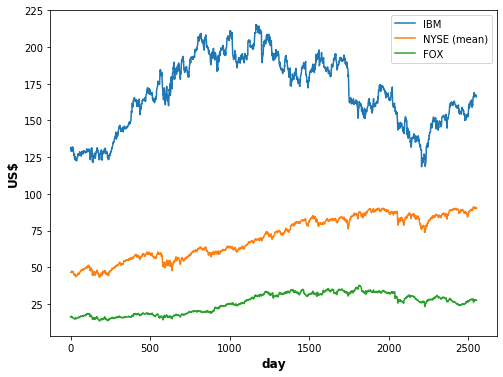

In [8]:
plotOpenPriceSeries(pricesDf)

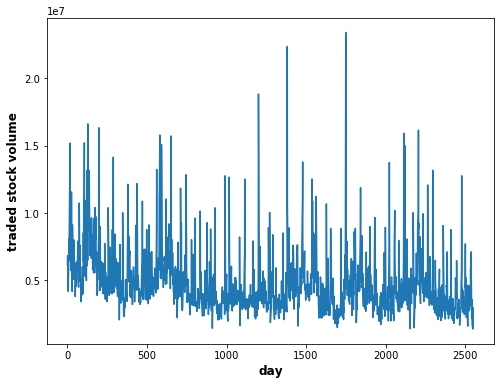

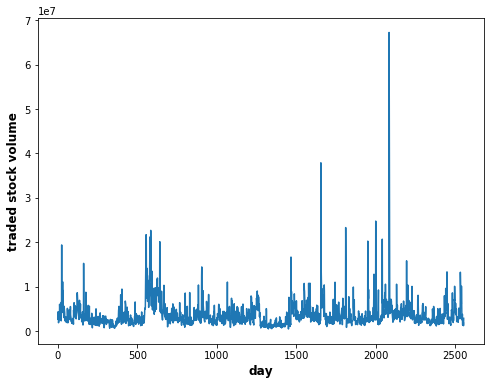

In [10]:
plotIbmFoxVolumes(pricesDf)

#### Passo 5

Reduzir a dimensionalidade dos dados. Foi decidido não fazer isso. No processo, porém, algumas considerações foram feitas que devem ajudar na fase de preparação dos dados. Essas considerações foram anotadas no relatório de carregamento e descrição dos dados, na seção "Considerações".

#### Passo 6

Exploração dos dados, em termos gerais.